# Part 1: The XOR Problem

## Why XOR?

XOR (exclusive or) is a simple logical operation:
- If inputs are **different** → output 1
- If inputs are **the same** → output 0

| Input A | Input B | Output |
|---------|---------|--------|
| 0 | 0 | 0 |
| 0 | 1 | 1 |
| 1 | 0 | 1 |
| 1 | 1 | 0 |

### The Historical Importance

In 1969, Minsky and Papert proved that a single-layer perceptron (one neuron)
**cannot learn XOR**. This caused the first "AI Winter" — people thought neural
networks were fundamentally limited.

The solution? **Hidden layers.** A network with at least one hidden layer CAN
learn XOR. This notebook proves it.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Our training data: XOR
x = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

y = np.array([
    [0],
    [1],
    [1],
    [0]
])

In [5]:
print("XOR dataset:")
print("-" * 30)
for i in range(len(x)):
    print(f"Input: {x[i]} -> Output: {y[i]}")

XOR dataset:
------------------------------
Input: [0 0] -> Output: [0]
Input: [0 1] -> Output: [1]
Input: [1 0] -> Output: [1]
Input: [1 1] -> Output: [0]


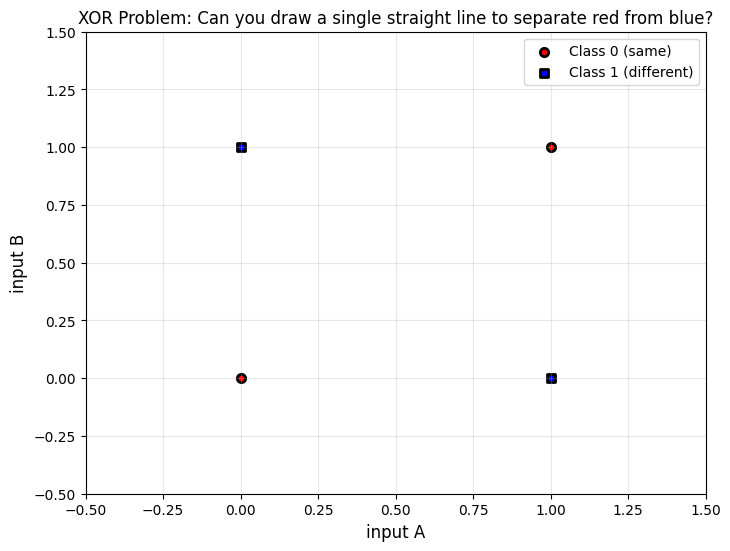


❌ A single straight line CANNOT separate these classes.
✅ This is why we need hidden layers — they create non-linear boundaries.


In [6]:
plt.figure(figsize=(8, 6))
for i in range(len(x)):
    color="red" if y[i] == 0 else "blue"
    marker="o" if y[i] == 0 else "s"
    plt.scatter(x[i][0], x[i][1], c=color, marker=marker, edgecolors="black", linewidths=2)

plt.xlabel("input A", fontsize=12)
plt.ylabel("input B", fontsize=12)
plt.title('XOR Problem: Can you draw a single straight line to separate red from blue?',
    fontsize=12)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.grid(True, alpha=0.3)
plt.legend(['Class 0 (same)', 'Class 1 (different)'], loc='upper right')
plt.show()

print("\n❌ A single straight line CANNOT separate these classes.")
print("✅ This is why we need hidden layers — they create non-linear boundaries.")


---
# Part 2: Building the Neural Network

## Our Architecture

```
Input Layer (2 neurons) → Hidden Layer (4 neurons) → Output Layer (1 neuron)
```

- **Input:** 2 values (the two XOR inputs)
- **Hidden:** 4 neurons with sigmoid activation
- **Output:** 1 neuron with sigmoid activation (gives us 0-1 probability)

### Why Sigmoid?

For this educational example, we use sigmoid everywhere because:
1. Output is naturally between 0 and 1 (matches our target)
2. The math is clean and easy to follow
3. It's historically important

Sigmoid function: σ(x) = 1 / (1 + e⁻ˣ)

In practice, you'd use ReLU for hidden layers. But sigmoid helps us see
what's happening.

In [12]:
INPUT_SIZE = 2
HIDDEN_SIZE = 4
OUTPUT_SIZE = 1
# multiply the weights with 0.5 to avoid explosive gradients(if not applied: big weights*inputs -> big hidden activations
# -> big output error contribution -> large gradients for weights -> next forward pass even bigger activations)
weights_input_hidden = np.random.randn(INPUT_SIZE, HIDDEN_SIZE) * 0.5
bias_hidden = np.zeros((1, HIDDEN_SIZE))

In [13]:
weights_hidden_output = np.random.randn(HIDDEN_SIZE, OUTPUT_SIZE) * 0.5
bias_output = np.zeros((1, OUTPUT_SIZE))

In [14]:
print("Network initialised with random weights")
print(f"Input -> hidden layer weights {weights_input_hidden.shape}")
print(f"hidden -> output layer weights {weights_hidden_output.shape}")
print(f"total parameters: {weights_hidden_output.size + bias_output.size + weights_input_hidden.size + bias_hidden.size}")

Network initialised with random weights
Input -> hidden layer weights (2, 4)
hidden -> output layer weights (4, 1)
total parameters: 17


## The Activation Function: Sigmoid

Sigmoid squashes any number into the range (0, 1):
- Large positive numbers → close to 1
- Large negative numbers → close to 0
- Zero → exactly 0.5

We also need its derivative for backpropagation.

In [15]:
def sigmoid(x):
    return 1 / 1 + np.exp(-x)

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

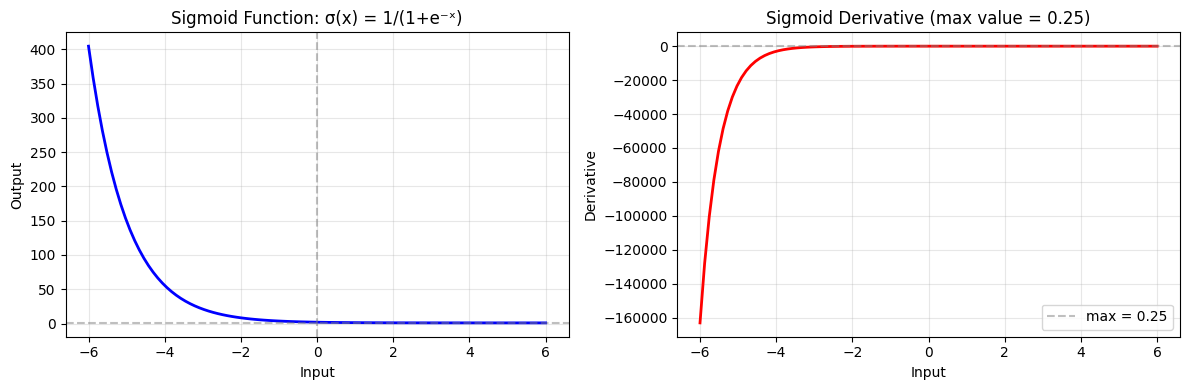

In [16]:
# Visualize sigmoid
x_range = np.linspace(-6, 6, 100)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x_range, sigmoid(x_range), 'b-', linewidth=2)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Sigmoid Function: σ(x) = 1/(1+e⁻ˣ)')
plt.grid(True, alpha=0.3)


plt.subplot(1, 2, 2)
plt.plot(x_range, sigmoid_derivative(x_range), 'r-', linewidth=2)
plt.axhline(y=0.25, color='gray', linestyle='--', alpha=0.5, label='max = 0.25')
plt.xlabel('Input')
plt.ylabel('Derivative')
plt.title('Sigmoid Derivative (max value = 0.25)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
print("\nNotice: The maximum derivative is only 0.25!")
print("   This is the vanishing gradient problem.")
print("   10 layers: 0.25^10 = ", 0.25**10)


Notice: The maximum derivative is only 0.25!
   This is the vanishing gradient problem.
   10 layers: 0.25^10 =  9.5367431640625e-07


## Forward Pass

The forward pass is how data flows through the network:

1. **Input → Hidden:** Multiply inputs by weights, add bias, apply activation
2. **Hidden → Output:** Multiply hidden by weights, add bias, apply activation

Let's trace through exactly what happens.

In [19]:
def forward(x):
    z_hidden = np.dot(x, weights_input_hidden) + bias_hidden
    a_hidden = sigmoid(z_hidden)
    
    z_output = np.dot(a_hidden, weights_hidden_output) + bias_output
    a_output = sigmoid(z_output)

    return z_output, z_hidden, a_hidden, a_output

In [25]:
z_h, z_o, a_h, predictions = forward(x)

In [26]:
print("Forward pass with UNTRAINED network:")
print("-" * 50)
for i in range(len(x)):
    print(f"Input: {x[i]} → Prediction: {predictions[i][0]:.4f} (Target: {y[i][0]})")

print("\n❌ Predictions are garbage — the network hasn't learned anything yet.")

Forward pass with UNTRAINED network:
--------------------------------------------------
Input: [0 0] → Prediction: 1.0219 (Target: 0)
Input: [0 1] → Prediction: 1.0337 (Target: 1)
Input: [1 0] → Prediction: 1.0037 (Target: 1)
Input: [1 1] → Prediction: 1.0110 (Target: 0)

❌ Predictions are garbage — the network hasn't learned anything yet.


## Loss Function: Mean Squared Error

Loss measures **how wrong** our predictions are. Lower = better.

**MSE = mean((prediction - target)²)**

We square the error so:
- All errors are positive
- Big errors are penalized more than small errors

In [27]:
def compute_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [28]:
initial_loss = compute_loss(y, predictions)
print(f"Initial loss (untrained): {initial_loss:.4f}")
print("This number should decrease as we train more")

Initial loss (untrained): 0.5169
This number should decrease as we train more


# Part 3: Backpropagation

This is where the magic happens. Backprop answers: **"Which weights caused the error, and how much?"**

## The Chain of Blame

1. Calculate error at output
2. Figure out how much each output weight contributed
3. Propagate error back to hidden layer
4. Figure out how much each hidden weight contributed
5. Adjust all weights proportionally

The math uses the chain rule from calculus, but the intuition is simple:
**blame flows backward.**